In [1]:
feature_names = [
   'linear',            # 1
   'nonlinear_square',  # 2
   'nonlinear_sin',     # 3
   'interaction_1',     # 4
   'interaction_2',     # 5
   'interaction_3',     # 6
   'noise_1',           # 7
   'noise_2',           # 8
   'noise_3',           # 9
   'noise_4',           # 10
   'noise_5',           # 11
   'noise_6',           # 12
   'noise_7',           # 13
   'noise_8',           # 14
   'noise_9',           # 15
   'noise_10'           # 16
]

In [2]:
def X2y(X, with_error = True):
    
    # functional form of the dependence between y and X
    y_star = X['linear'] + X['nonlinear_square'] ** 2 + np.sin(3 * X['nonlinear_sin']) + (X['interaction_1'] * X['interaction_2'] * X['interaction_3'])
    
    # add random error called epsilon (this will be used for creating y)
    if with_error:
        np.random.seed(0)
        epsilon = np.random.normal(0, .1, len(y_star))
        return y_star + epsilon
    
    # do not add error (this will be used for prediction)
    else:
        return y_star

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# make X and y
np.random.seed(0)
X = pd.DataFrame(np.random.normal(size = (20_000, len(feature_names))), columns = feature_names)
y = X2y(X, with_error = True)

# make X_trn, X_tst, y_trn, y_tst
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size = .5, random_state = 0)

In [3]:
# define a sklearn compatible wrapper for our data generating function
class UnbeatableRegressor():
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        pass  
    
    def predict(self, X):
        return np.array(X2y(X, with_error = False))
    
    def score(self, X, y):
        return mean_absolute_error(y, self.predict(X))

In [26]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# dictionary of models that will be used for comparison
models = {
    'DummyRegressor': DummyRegressor(),
    'LinearRegression': LinearRegression(),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors = int(np.sqrt(len(X_trn)))),
    'SupportVectorRegressor': SVR(C = .1),
    'RandomForestRegressor': RandomForestRegressor(max_depth = 5),
    'XGBRegressor': XGBRegressor(max_depht = 5),
    'LGBMRegressor': LGBMRegressor(num_leaves = 10),
    'UnbeatableRegressor': UnbeatableRegressor()
}

In [27]:
from sklearn.metrics import mean_absolute_error
from eli5.sklearn import PermutationImportance

mae = pd.DataFrame(columns = ['train', 'test'])
fi = pd.DataFrame(columns = feature_names)

for model_name in list(models.keys()):

    # fit model
    models[model_name].fit(X_trn, y_trn)
    
    # compute mean absolute error of model in train and test set
    mae.loc[model_name,:] = [mean_absolute_error(y_trn, models[model_name].predict(X_trn)), mean_absolute_error(y_tst, models[model_name].predict(X_tst))]
    
    # compute feature importances of model
    try:
        feature_importances_ = models[model_name].feature_importances_
    except:
        feature_importances_ = PermutationImportance(models[model_name], cv = 'prefit', n_iter = 3).fit(X_trn, y_trn).feature_importances_
    fi.loc[model_name, :] = feature_importances_ / feature_importances_.sum()
    
fi.fillna(0, inplace = True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


[16:41:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { max_depht } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




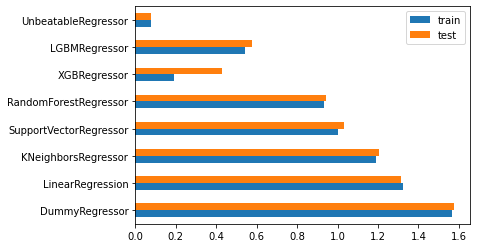

In [28]:
mae.plot.barh()

In [39]:
fi

,linear,nonlinear_square,nonlinear_sin,interaction_1,interaction_2,interaction_3,noise_1,noise_2,noise_3,noise_4,noise_5,noise_6,noise_7,noise_8,noise_9,noise_10
DummyRegressor,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LinearRegression,0.990348,0.000271,0.002148,0.004026,0.000025,0.000149,0.001086,-0.000007,0.000593,0.000074,-0.000005,0.000484,0.000378,-0.000041,0.000155,0.000316
KNeighborsRegressor,0.403464,0.360343,0.012217,0.074158,0.076490,0.077070,-0.000293,-0.000227,0.001017,0.001012,-0.000968,-0.000780,0.000421,-0.005113,0.001272,-0.000084
SupportVectorRegressor,0.404318,0.439326,0.007901,0.038604,0.036810,0.035857,0.003750,0.003112,0.002887,0.004744,0.004248,0.004652,0.003574,0.002479,0.003777,0.003960
RandomForestRegressor,0.329358,0.659570,0.001628,0.000649,0.003900,0.002203,0.000239,0.000090,0.000342,0.000195,0.000160,0.000212,0.000246,0.000915,0.000128,0.000166
XGBRegressor,0.193383,0.460054,0.111072,0.034741,0.050875,0.052839,0.011164,0.011794,0.009744,0.008316,0.008744,0.007798,0.008044,0.011629,0.009001,0.010803
LGBMRegressor,0.146667,0.250000,0.232222,0.082222,0.093333,0.086667,0.013333,0.003333,0.021111,0.005556,0.014444,0.002222,0.013333,0.020000,0.012222,0.003333
UnbeatableRegressor,0.209452,0.240513,0.148705,0.133412,0.132965,0.134953,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000


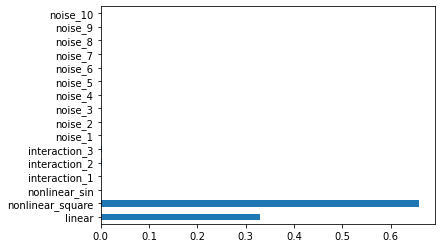

In [41]:
fi.loc['RandomForestRegressor'].plot.barh()

In [31]:
!pip install Boruta

     |################################| 56 kB 1.1 MB/s eta 0:00:011


In [32]:
from boruta import BorutaPy

# instantiate random forest
forest = RandomForestRegressor(n_jobs = -1, max_depth = 5)

# fit boruta
boruta_selector = BorutaPy(forest, n_estimators = 'auto', random_state = 0)
boruta_selector.fit(np.array(X_trn), np.array(y_trn))

# store results
boruta_ranking = boruta_selector.ranking_
selected_features = np.array(feature_names)[boruta_ranking <= 2]

- **ranking 1: confirmed features** (these features bear some signal with respect to the target variable, so they should be kept);
- **ranking 2: tentative features** (Boruta is indecisive about these features, the choice is up to you, I am a conservative guy: my suggestion is to keep them);
- **ranking 3 or higher: rejected features** (these are just noise, so they should be dropped).

In [33]:
boruta_ranking

array([ 1,  1,  1,  2,  1,  1,  5, 12,  4,  8,  7,  6, 10,  3,  9, 10])

In [34]:
selected_features

array(['linear', 'nonlinear_square', 'nonlinear_sin', 'interaction_1',
       'interaction_2', 'interaction_3'], dtype='<U16')

In [43]:
boruta_selector.support_

array([ True,  True,  True, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False])

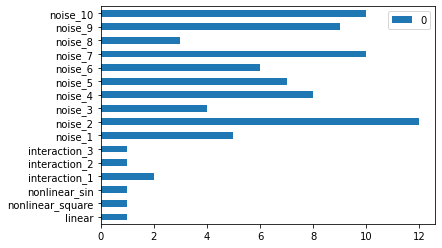

In [45]:
boruta_selection_frame = pd.DataFrame(boruta_ranking, feature_names)
boruta_selection_frame.plot.barh()